# Ariane 5 Vulcain Engine

This notebook attempts to use Bamboo to recreate experimental and simulation data produced for the Ariane 5's Vulcain engine by Messerschmitt-Bölkow-Blohm (MBB).

Key points on the Vulcain engine:
- The combustion chamber is cooled seperately to the nozzle extension
- The nozzle extension is cooled by dump cooling
- The combustion chamber is regeneratively cooled

We will only attempt to model the regeneratively cooled combustion chamber.

### Conclusions:
- Bamboo seems to do a reasonable job at predicting heat transfer rates (overpredicted the peak by 7.07%)
- Bamboo seems to noticeably underpredict the coolant exit temperature (by 14.04% in this case). It's possible this is either due to the incorrect coolant mass flow rate being used (it was assumed that all fuel mass flow rate went through the cooling channels - it may be possible some does not and simply goes straight to dump cooling). Otherwise, it's possible the error is due to nucleate boiling, which would increase the heat flux and is a phenomenom not accounted for by bamboo.
- Bamboo has a sharp peak in heat transfer rate at the throat, whereas the MBB data is smoother at the throat. This is likely due to Bamboo neglecting any axial heat transfer (which would smooth out the peak).
- It's important to use the throat conditions in pypropep to get the perfect gas gamma, otherwise the perfect gas model deviates significantly from equilibrium (e.g. CEA or ProPEP) and real life values.

### References:

- [1] - Kirner et al 1993, Development Status of the Vulcain Thrust Chamber (http://ftp.demec.ufpr.br/CFD/bibliografia/propulsao/kirner_et_al_1993.pdf)
- [2] - https://www.researchgate.net/publication/224789875_Thermomechanical_Analysis_and_Optimization_of_Cryogenic_Liquid_Rocket_Engines 
- [3] - https://www.macro-inc.com/NASADocs/AdvanceRocketEnginesEN-AVT-150-06.pdf
- [4] - https://www.sto.nato.int/publications/STO%20Educational%20Notes/RTO-EN-AVT-150/EN-AVT-150-05.pdf (note this link downloads a PDF)


### Uses of references:
- [1] - Predicted and experimental coolant temperatures and heat transfer rates for the Vulcain engine, from page 10.
- [2] - Thermal conductivity of the walls (310 W/m/K), from page 844.
- [3] - Cooling channel dimensions were estimated using the image on page 21.
- [4] - Turbopump exit pressure, assumed to be the coolant inlet pressure, from the graph on page 3 (noting that Vulcain is a gas-generator cycle with 1450 psi chamber pressure, giving ~2400 psi pump exit pressure (165 bar))



In [1]:
import bamboo as bam
import pypropep as ppp
from CoolProp.CoolProp import PropsSI
import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 130

Using a an online graph image-to-data converter, we can obtain the raw data from MBB (Messerschmitt-Bölkow-Blohm).

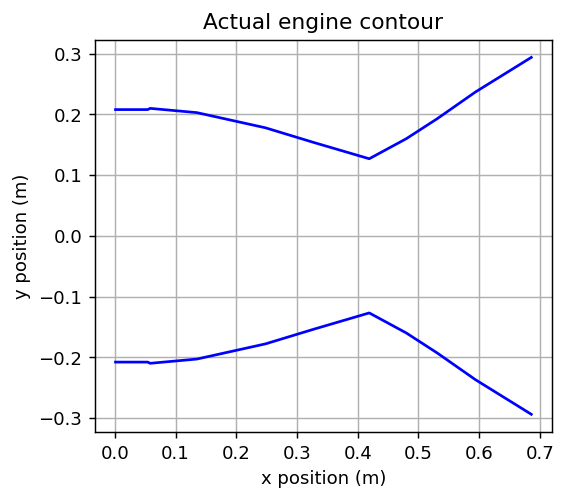

In [2]:
#'x' key corresponds to position in metres (0 = beginning of chamber). 'y' corresponds to the data.

#Coolant temperature in K 
coolant_temperature_data = {"x":[-0.002,0.012,0.029,0.045,0.197,0.26,0.32,0.37,0.424,0.485,0.529,0.592,0.648,0.687],
                            "y":[92.203,90.169,88.136,86.441,68.983,61.186,53.39,45.763,38.814,30.339,24.407,17.119,11.186,6.78]}

#Heat transfer rate in W/cm^2
heat_transfer_rate = {"x":[-0.003,0.022,0.036,0.049,0.062,0.086,0.113,0.129,0.152,0.171,0.192,0.205,0.221,0.244,0.27,0.294,0.31,0.327,0.342,0.36,0.368,0.382,0.398,0.421,0.439,0.447,0.452,0.465,0.477,0.49,0.5,0.512,0.524,0.534,0.548,0.564,0.58,0.596,0.612,0.631,0.647,0.664,0.688],
                      "y":[3374.422,3577.812,3697.997,3744.222,3762.712,3716.487,3661.017,3661.017,3670.262,3688.752,3707.242,3771.957,3818.182,3938.367,4114.022,4335.901,4539.291,4816.641,5075.501,5334.361,5574.73,5796.61,5935.285,5861.325,5648.69,5214.176,4983.051,4594.761,4298.921,3827.427,3522.342,3161.787,2930.663,2662.558,2440.678,2191.063,1996.918,1821.263,1710.324,1590.139,1479.199,1386.749,1322.034]}

#Engine contour (m) - up to the beginning of the nozzle extension.
engine_contour = {"x":[0.001,0.054,0.058,0.135,0.248,0.327,0.419,0.48,0.531,0.594,0.686],
                  "y":[0.208,0.208,0.21,0.203,0.178,0.154,0.127,0.16,0.193,0.237,0.294]}

#Plot the engine contour
fig, axs = plt.subplots()
axs.plot(engine_contour["x"], engine_contour["y"], color = 'blue')
axs.plot(engine_contour["x"], -np.array(engine_contour["y"]), color = 'blue')
axs.set_aspect('equal')
axs.grid()
plt.title("Actual engine contour")
axs.set_xlabel("x position (m)")
axs.set_ylabel("y position (m)")
plt.show()

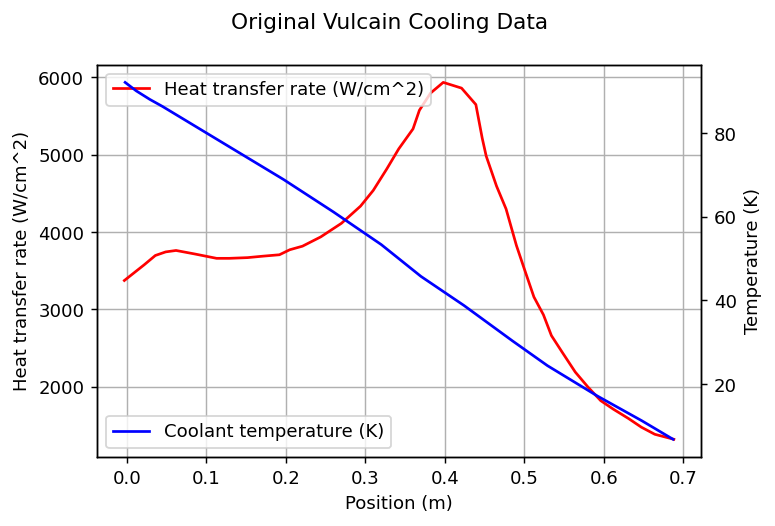

In [3]:
#Plot the original data from MBB
fig, ax1 = plt.subplots()
fig.suptitle("Original Vulcain Cooling Data")

#Plot heat transfer rates
ax1.plot(heat_transfer_rate["x"], heat_transfer_rate["y"], label="Heat transfer rate (W/cm^2)", color="red")

ax1.set_xlabel("Position (m)")
ax1.set_ylabel("Heat transfer rate (W/cm^2)")
ax1.grid()
ax1.legend(loc = "upper left")

#Plot coolant temperatures on the same axis
ax2 = ax1.twinx()       #Second axes that shares the same x-axis as ax1
ax2.plot(coolant_temperature_data["x"], coolant_temperature_data["y"], label="Coolant temperature (K)", color="blue")
ax2.set_ylabel("Temperature (K)")
ax2.legend(loc = 'lower left')

plt.show()

### Bamboo engine model

The Vulcain uses a liquid oxygen and liquid hydrogen fed system.

In [4]:
thrust = 1007.7e3   #N - in vacuum
isp = 439           #seconds - in vacuum
pc = 100e5          #chamber pressure
OF_ratio = 5.6      #by mass I believe

#Actual mass flow rate was incompatible with throat area (for perfect gas choking)
#Bamboo suggested using this value (which is slightly lower than the actual value of 234 kg/s)
mdot = 219.916 #thrust/(isp*9.81) 

#Use pypropep to get chamber temperature
ppp.init()
p_froz = ppp.FrozenPerformance()
lox = ppp.PROPELLANTS['OXYGEN (LIQUID)']
lh2 = ppp.PROPELLANTS['HYDROGEN (CRYOGENIC)']

#Add propellants by mass fractions
p_froz.add_propellants_by_mass([(lox, OF_ratio), (lh2, 1)])

#Adiabatic combustion using chamber pressure                      
p_froz.set_state(P = pc/1e5, Pe = 1)   

#Get results - use throat conditions for gamma and cp! Otherwise the perfect gas model deviates a lot from equilibrium calculations.
gamma = p_froz.properties[1].Isex   #pyrpopep uses 'Isex' for the ratio of specific heats. Index [1] means throat conditions
cp = 1000*p_froz.properties[1].Cp   #Cp is given in kJ/kg/K, we want J/kg/K
Tc = p_froz.properties[0].T         #Index [0] means chamber conditions


print(f"\nTotal mass flow rate = {mdot} kg/s")
print(f"Chamber temperature = {Tc} K")

print("\nCombustion product composition:")
print(p_froz.composition["throat"])

Loaded 1921 thermo species
Loaded 1031 propellants

Total mass flow rate = 219.916 kg/s
Chamber temperature = 3459.2606127242298 K

Combustion product composition:
[('H2O', 0.6493671319106238), ('H2', 0.2896925690851782), ('OH', 0.028980423622929952), ('H', 0.028801796474919292), ('O', 0.0016810512414820072), ('O2', 0.0014520541971763574), ('HO2', 1.7031381331243065e-05), ('H2O2', 7.94208687267654e-06), ('O3', 0.0)]


In [5]:
#Need to convert contour data into something we can use for Bamboo - shift the data so the throat occurs at x = 0.
throat_pos = 0.419
nozzle_x = (np.array(engine_contour["x"]) - throat_pos)[6:]
nozzle_y = np.array(engine_contour["y"])[6:]

chamber_x = (np.array(engine_contour["x"]) - throat_pos)[:7]
chamber_y = np.array(engine_contour["y"])[:7]

#Set up the engine object
perfect_gas = bam.PerfectGas(gamma = gamma, cp = cp)   
chamber_conditions = bam.ChamberConditions(pc, Tc, mdot)
nozzle = bam.Nozzle(type = "custom", xs = nozzle_x, ys = nozzle_y)

engine = bam.Engine(perfect_gas, chamber_conditions, nozzle)

In [6]:
#Engine geometry
engine.add_geometry(inner_wall_thickness = 1.7e-3,
                    style = "custom",
                    xs = chamber_x,
                    ys = chamber_y)


In [7]:
'''Transport properties'''
#Setup the exhaust gas transport properties - assume the exhaust gas is purely water for simplicity
def Pr_gas(T, p):
    return PropsSI("PRANDTL", "T", T, "P", p, "WATER")

def mu_gas(T, p):
    return PropsSI("VISCOSITY", "T", T, "P", p, "WATER")

def k_gas(T, p):
    return PropsSI("CONDUCTIVITY", "T", T, "P", p, "WATER")

gas_transport = bam.cooling.TransportProperties(type = "functions",
                                                Pr = Pr_gas,
                                                mu = mu_gas,
                                                k = k_gas)

#Set up the coolant transport properties
#Round temperatures up to 12 K - CoolProp seems unhappy below this for LH2
def Pr_coolant(T, p):
    if T < 12:
        T = 12
    return PropsSI("PRANDTL", "T", T, "P", p, "HYDROGEN")

def mu_coolant(T, p):
    if T < 12:
        T = 12
    return PropsSI("VISCOSITY", "T", T, "P", p, "HYDROGEN")

def k_coolant(T, p):
    if T < 12:
        T = 12
    return PropsSI("CONDUCTIVITY", "T", T, "P", p, "HYDROGEN")

def cp_coolant(T, p):
    if T < 12:
        T = 12
    return PropsSI("CPMASS", "T", T, "P", p, "HYDROGEN") 

def rho_coolant(T, p):
    if T < 12:
        T = 12
    return PropsSI("DMASS", "T", T, "P", p, "HYDROGEN") 

'''
def T_from_enthalpy(enthalpy, p):
    return PropsSI('T','H', enthalpy,'P', p, 'HYDROGEN')

def enthalpy_from_T(T, p):
    return PropsSI('H','T', T, 'P', p, 'HYDROGEN')
'''

#H2 doesn't seem to exactly 'boil-off' in the state it's in, so just use cp for coolant temperature rise, not enthalpies.
coolant_transport = bam.cooling.TransportProperties(type = "functions",
                                                    Pr = Pr_coolant,
                                                    mu = mu_coolant,
                                                    k = k_coolant,
                                                    cp = cp_coolant,
                                                    rho = rho_coolant)

#Add the gas transport properties to the engine
engine.add_exhaust_transport(gas_transport)

#Coolant transport properties will get used later when creating adding the CoolingJacket to the engine

In [8]:
#Wall material
vulcain_wall_material = bam.cooling.Material(E = float("NaN"), 
                                    sigma_y = float("NaN"), 
                                    poisson = float("NaN"), 
                                    alpha = float("NaN"), 
                                    k = 310, 
                                    c = float("NaN"))

In [9]:
#Dimensions estimated from the image in Reference [3]
engine.add_cooling_jacket(inner_wall_material = vulcain_wall_material, 
                          inlet_T = 6.78,                           
                          inlet_p0 = 165e5, 
                          coolant_transport = coolant_transport, 
                          mdot_coolant = mdot/(OF_ratio + 1), 
                          configuration = "vertical", 
                          channel_height = 9.1e-3,
                          blockage_ratio = 0.5,
                          number_of_ribs = 288)

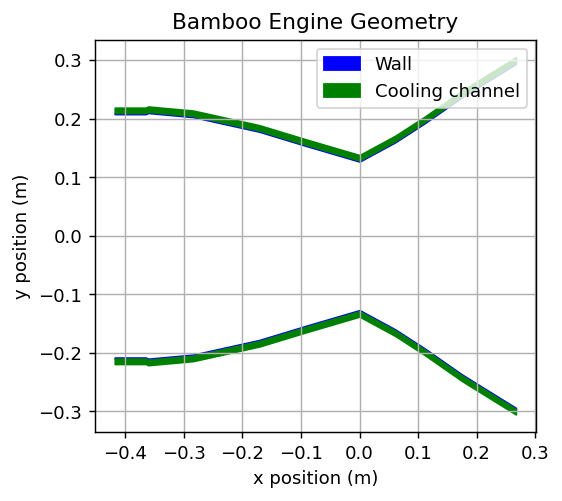

In [10]:
engine.plot_geometry()
plt.title("Bamboo Engine Geometry")
plt.show()

In [11]:
#Run simulation without fudge factor
bamboo_data = engine.steady_heating_analysis(to_json = False, 
                                             h_gas_model = 'bartz-sigma', 
                                             h_coolant_model = 'gnielinski')

NOTE: No enthalpy data provided for the coolant - will use specific heat capacity to predict temperature rises.


In [12]:
#Convert heat transfer rates to per unit area - divide by the circumference
q_per_area = np.zeros(len(bamboo_data['q_dot']))
for i in range(len(q_per_area)):
    q_per_area[i] = bamboo_data['q_dot'][i]/(2*np.pi*engine.y(bamboo_data["x"][i]))


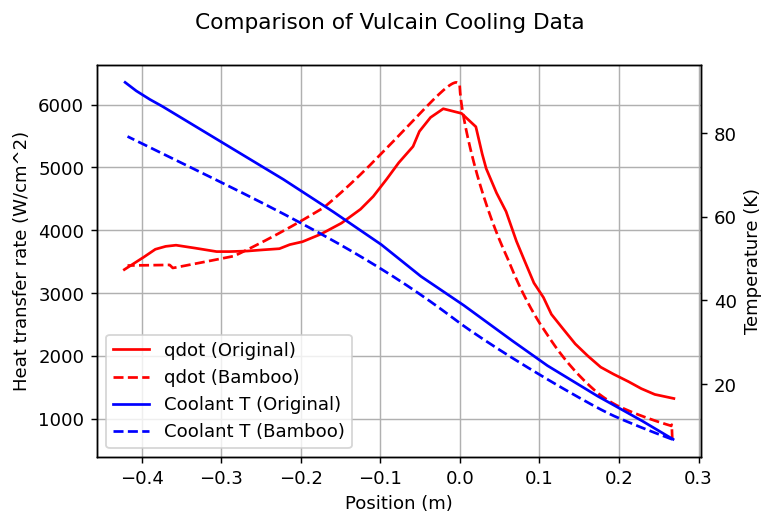

Actual coolant exit temperature (MBB) = 92.203 K
Predicted coolant exit temperature (Bamboo) = 79.25940764457428 K
Percentage error in coolant exit temperature = 14.04%

Actual peak heat transfer rate (MBB) = 5935.285 W/cm2
Predicted peak heat transfer rate (Bamboo) = 6355.062026534959 W/cm2
Percentage error in peak heat transfer rate = 7.07%


In [13]:
#Compare results with data from paper
fig, ax1 = plt.subplots()
fig.suptitle("Comparison of Vulcain Cooling Data")

#Plot heat transfer rates
ax1.plot(np.array(heat_transfer_rate["x"]) - throat_pos, heat_transfer_rate["y"], label="qdot (Original)", color="red")
ax1.plot(bamboo_data["x"], q_per_area*(1e-2)**2, label="qdot (Bamboo)", color="red", linestyle = "--")

ax1.set_xlabel("Position (m)")
ax1.set_ylabel("Heat transfer rate (W/cm^2)")
ax1.grid()

#Plot coolant temperatures on the same axis
ax2 = ax1.twinx()       
ax2.plot(np.array(coolant_temperature_data["x"]) - throat_pos, coolant_temperature_data["y"], label="Coolant T (Original)", color="blue")
ax2.plot(bamboo_data["x"], bamboo_data["T_coolant"], label="Coolant T (Bamboo)", color="blue", linestyle = "--")

ax2.set_ylabel("Temperature (K)")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc = 'lower left')

plt.show()

print(f'Actual coolant exit temperature (MBB) = {coolant_temperature_data["y"][0]} K')
print(f'Predicted coolant exit temperature (Bamboo) = {bamboo_data["T_coolant"][-1]} K')
percent_error = 100*(bamboo_data["T_coolant"][-1] - coolant_temperature_data["y"][0])/coolant_temperature_data["y"][0]
print(f'Percentage error in coolant exit temperature = {abs(percent_error):.2f}%\n')

print(f'Actual peak heat transfer rate (MBB) = {max(heat_transfer_rate["y"])} W/cm2')
print(f'Predicted peak heat transfer rate (Bamboo) = {max(q_per_area*(1e-2)**2)} W/cm2')
percent_error = 100*(max(q_per_area*(1e-2)**2) - max(heat_transfer_rate["y"]))/max(heat_transfer_rate["y"])
print(f'Percentage error in peak heat transfer rate = {abs(percent_error):.2f}%')
